# Identifying Fraudulent Credit Card Transactions Using a One-Class Support Vector Machine (SVM) Model

## Resources 

- [Geeks for Geeks - Understanding One-Class Support Vector Machines](https://www.geeksforgeeks.org/understanding-one-class-support-vector-machines/)
- [Scikit-learn - OneClassSVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)

## Load Dataset

In [1]:
import pandas as pd 

df = pd.read_csv("creditcard.csv")

target_feature = "Class"
input_features = list(df.columns)
input_features.remove(target_feature)

print(df.shape)
print(f"Percentage fraudulent transactions: {df["Class"].sum() / df.shape[0]}")
print(f"Target Variable: {target_feature}")
print(f"Input Variables: {input_features}")

(284807, 31)
Percentage fraudulent transactions: 0.001727485630620034
Target Variable: Class
Input Variables: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


## Train / Test Split 

One-class SVMs are trained only on the "normal" class. This requires a little extra work to separate out a training class compromised of only legitimate transactions.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

def ocsvm_train_test_split(X, y):

    # Splitting data into training and testing sets, with only normal transactions (Class = 0) for training
    X_train = X[y == 0]
    X_test, y_test = X[y == 1].copy(), y[y == 1].copy()


    # Include some normal transactions in the test set as well
    X_train, X_test_normal, y_train, y_test_normal = train_test_split(X_train, 
                                                                    y[y == 0], 
                                                                    test_size= 0.2, 
                                                                    random_state = 42)


    X_test = pd.concat([X_test, X_test_normal]) 
    y_test = pd.concat([y_test, y_test_normal])

    
    return X_train, X_test, y_train, y_test


# # Sample dataset, separate input and target columns
df_sampled = df.sample(frac = 0.2) #random_state=1)
X = df_sampled.drop(columns = [target_feature])
y = df_sampled[target_feature] 

# X = df.drop(columns = [target_feature])
# y = df[target_feature] 

X_train, X_test, y_train, y_test = ocsvm_train_test_split(X, y)

print(y.value_counts())
print(f"Percentage fraudulent transactions: {y.sum() / len(y)}")

Class
0    56854
1      107
Name: count, dtype: int64
Percentage fraudulent transactions: 0.0018784782570530714


## Data Scaling

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Fit Model and Predict Class

In [13]:
from sklearn.svm import OneClassSVM

# Instantiate model 
oc_svm = OneClassSVM(kernel = 'rbf', 
                     nu = 0.5, 
                     gamma = 0.5)

oc_svm.fit(X_train_scaled)                     # Train model
predictions = oc_svm.predict(X_test_scaled)    # Predict outliers in the test set
predictions = (predictions == -1).astype(int)  # Convert predictions to binary: 1 for inliers (normal), -1 for outliers (fraud)

Time to run: 

| kernel | nu | gamma | sample size | Time      |
|--------|----|-------|-------------|-----------|
| linear | 0.5| 0.1   | .2          | 51.5s     |
| linear | 0.5| 0.2   | .2          | 49.4s     |
| linear | 0.5| 0.3   | .2          | 49.6s     |
| linear | 0.5| 0.4   | .2          | 48.4s     |
| linear | 0.5| 0.5   | .2          | 50.3s     |
| linear | 0.5| scale | .2          | 47.6s     | 
| rbf    | 0.5| scale | .2          | 3m 17.6 s |


## Evaluate Model Performance

In [25]:
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.03      0.06     11375
           1       0.00      0.29      0.00        89

    accuracy                           0.04     11464
   macro avg       0.43      0.16      0.03     11464
weighted avg       0.85      0.04      0.06     11464



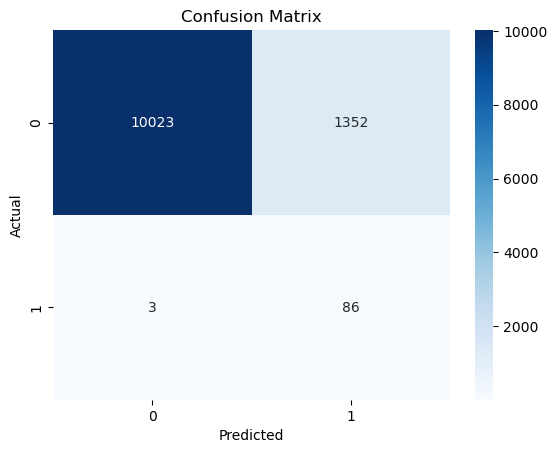

In [23]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_val, y_pred):
    
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(y_test, predictions)

Initial result, rbf, nu = .1, gamma = .1

```
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     56863
           1       0.07      0.91      0.13       492

    accuracy                           0.90     57355
   macro avg       0.54      0.90      0.54     57355
weighted avg       0.99      0.90      0.94     57355
```

In [9]:
y_test.value_counts()

Class
0    11371
1      107
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
import time

# Hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'nu': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only relevant for poly kernel
}

# Statified K Fold ensures each fold for the grid search contains the same proportion of classes 
stratified_kfold = StratifiedKFold(n_splits = 5, shuffle = True)

# Cross-Validation and Grid Search
grid_search = GridSearchCV(OneClassSVM(), 
                           param_grid, 
                           cv = stratified_kfold,
                           scoring = "roc_auc", 
                           verbose = 2, 
                           n_jobs = -1)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

total_training_time = end_time - start_time 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.1; total time=  17.2s
[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.1; total time=  17.3s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.1; total time=  18.1s
[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.1; total time=  18.2s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.1; total time=  20.4s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.2; total time=  32.3s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.2; total time=  33.0s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.2; total time=  34.0s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.2; total time=  36.1s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.2; total time=  40.9s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END ..........degree=2, gamma=scale, kernel=rbf, nu=0.1; total time= 1.2min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END ..........degree=2, gamma=scale, kernel=rbf, nu=0.1; total time= 1.3min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END ..........degree=2, gamma=scale, kernel=rbf, nu=0.1; total time= 1.3min
[CV] END ..........degree=2, gamma=scale, kernel=rbf, nu=0.1; total time= 1.3min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.5; total time= 1.4min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.5; total time= 1.4min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.5; total time= 1.4min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.5; total time= 1.4min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END ..........degree=2, gamma=scale, kernel=rbf, nu=0.1; total time= 1.5min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .......degree=2, gamma=scale, kernel=linear, nu=0.5; total time= 2.0min


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .........degree=2, gamma=scale, kernel=poly, nu=0.1; total time=  44.5s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .........degree=2, gamma=scale, kernel=poly, nu=0.1; total time=  45.2s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .........degree=2, gamma=scale, kernel=poly, nu=0.1; total time=  44.5s


/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV] END .........degree=2, gamma=scale, kernel=poly, nu=0.1; total time=  50.2s
[CV] END .........degree=2, gamma=scale, kernel=poly, nu=0.1; total time=  50.2s


KeyboardInterrupt: 

In [ ]:
# Access and print the results 
results = pd.DataFrame(grid_search.cv_results_) 
print(f"Total Training Time: {total_training_time:.2f} seconds") 
print(results[['params', 'mean_fit_time', 'mean_score_time']])

for i, param in enumerate(results['params']): 
    print(f"Parameters: {param}") 
    print(f"Fit Time: {results['mean_fit_time'].iloc[i]:.2f} seconds") 
    print(f"Score Time: {results['mean_score_time'].iloc[i]:.2f} seconds") 
    print('-' * 40)

In [ ]:
# Best model
best_oc_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predictions
predictions = best_oc_svm.predict(X_test_scaled)
predictions = (predictions == -1).astype(int)

# Evaluation
print("Classification Report:\n", classification_report(y_test, predictions))
print("ROC-AUC Score:", roc_auc_score(y_test, predictions))